# PatternMind loading dataset and performing EDA

### Imports

We import all the Python libraries needed for the Exploratory Data Analysis

In [1]:
import os
import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import drive


### Mounting drive and locating dataset

We mount Google Drive to Colab so the notebook can access the ZIP file containing the PatternMind dataset.
We define two important variables:
ZIP_PATH → location of the dataset ZIP file inside Drive
EXTRACT_DIR → folder where the ZIP will be extracted.

This ensures that the dataset can be accessed.

In [2]:
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# Path to your ZIP file or extracted dataset
ZIP_PATH = "/content/drive/MyDrive/patternmind_dataset.zip"
UNZIP_DIR = "/content/patternmind_unzipped"
DATASET_DIR_NAME = "patternmind_dataset"   # the folder inside the zip

DATA_ROOT = os.path.join(UNZIP_DIR, DATASET_DIR_NAME)
print("Will use DATA_ROOT:", DATA_ROOT)


if not os.path.isdir(DATA_ROOT):
    os.makedirs(UNZIP_DIR, exist_ok=True)
    !unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"
    print("Unzipped dataset.")
else:
    print("Dataset already unzipped.")

Will use DATA_ROOT: /content/patternmind_unzipped/patternmind_dataset
Unzipped dataset.


We are listing the contents of the extracted directory to confirm proper extraction.

The dataset root folder can be seen:
System folders like __MACOSX (typical from macOS ZIP archives)

In [4]:
print("DATA_ROOT exists:", os.path.isdir(DATA_ROOT))
print("Contents of UNZIP_DIR:", os.listdir(UNZIP_DIR))

DATA_ROOT exists: True
Contents of UNZIP_DIR: ['__MACOSX', 'patternmind_dataset']


### Verifying structure



We examine the dataset root folder and collect all subfolders — each subfolder represents one class category.

In [5]:
import os

root = DATA_ROOT   # THIS is /content/patternmind_unzipped/patternmind_dataset

folders = [d for d in os.listdir(root)
                 if os.path.isdir(os.path.join(root, d))]

print("Number of class folders:", len(folders))
print("First 20 class folders:", folders[:20])


Number of class folders: 233
First 20 class folders: ['chandelier', 'yo-yo', 'bowling-pin', 'motorbikes', 'lightning', 'menorah', 'car-tire', 'american-flag', 'mattress', 'mountain-bike', 'mars', 'bear', 'comet', 'touring-bike', 'grand-piano-101', 'drinking-straw', 'grapes', 'brain', 'kayak', 'galaxy']


### Collect all images

This block recursively scans the dataset directory and collects paths for all.jpg, .jpeg, and .png files.
Outcome:
A list of 25,557 images is detected.
Sample paths are printed for inspection.
This step creates the base list used for EDA and future dataloader creation.

In [7]:
DATA_DIR = UNZIP_DIR  # dataset root
extensions = ['*.jpg', '*.jpeg', '*.png']
image_paths = []

for ext in extensions:
    image_paths.extend(glob.glob(os.path.join(DATA_DIR, '**', ext), recursive=True))

print("Total images found:", len(image_paths))
image_paths[:5]


Total images found: 25557


['/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_92.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_85.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_36.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_20.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_06.jpg']

### Extract foler names

Each image is stored inside a folder named after the class (e.g., "hamburger").

Extracts the parent folder name for every image
Builds a pandas DataFrame with two columns:
`path` → `full path of the image`
`label` → `class name`
This structure simplifies counting classes, balancing data, and linking images to labels.

In [8]:
# folder name = class label
def get_class_from_path(path):
    return os.path.basename(os.path.dirname(path))

labels = [get_class_from_path(p) for p in image_paths]

df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

df.head()

,path,label
0,/content/patternmind_unzipped/patternmind_data...,chandelier
1,/content/patternmind_unzipped/patternmind_data...,chandelier
2,/content/patternmind_unzipped/patternmind_data...,chandelier
3,/content/patternmind_unzipped/patternmind_data...,chandelier
4,/content/patternmind_unzipped/patternmind_data...,chandelier


### Count images per class

Here the notebook computes the number of images per class:
value_counts() gives a frequency table

The histogram visualizes distribution of class sizes
It identifies whether the dataset is `balanced` or `imbalanced`
Evaluate whether augmentation or resampling might be needed in modeling.

In [9]:
class_counts = df["label"].value_counts().sort_values(ascending=False)

print("Number of classes:", len(class_counts))
class_counts.head(10)


Number of classes: 233


,count
label,
clutter,761
airplanes,720
motorbikes,719
faces-easy,396
t-shirt,330
hammock,257
billiards,251
horse,246
ladder,223


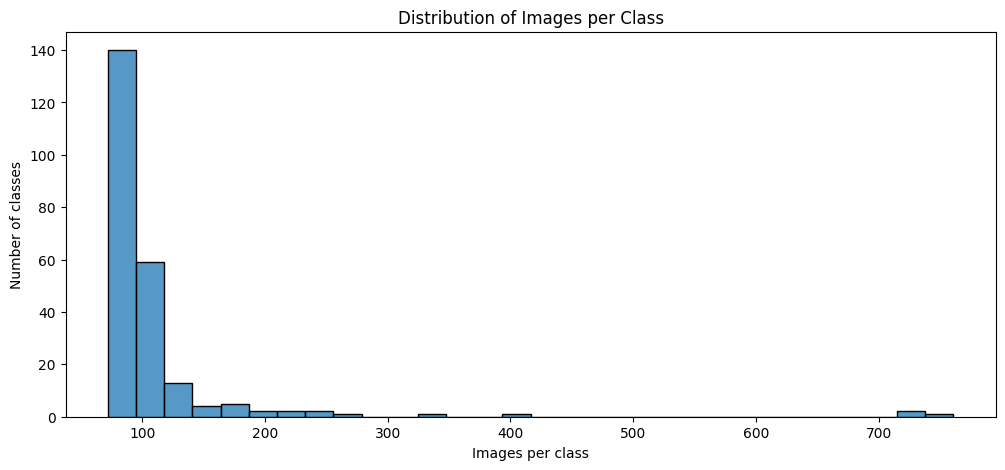

In [10]:
plt.figure(figsize=(12, 5))
sns.histplot(class_counts, bins=30)
plt.title("Distribution of Images per Class")
plt.xlabel("Images per class")
plt.ylabel("Number of classes")
plt.show()

### Check corrupted images

Iterates over all image paths and attempts to open and verify each image.
If a file fails verification, it is added to `bad_files`.


In [11]:
bad_files = []

for path in tqdm(image_paths, desc="Checking corrupted images"):
    try:
        img = Image.open(path)
        img.verify()   # verify file integrity
    except Exception:
        bad_files.append(path)

print("Corrupted files found:", len(bad_files))



Checking corrupted images: 100%|██████████| 25557/25557 [00:02<00:00, 9054.44it/s]

Corrupted files found: 0


### File extensions

Counts the frequency of file extensions (e.g., .jpg, .png).
Useful for understanding dataset consistency and detecting unexpected formats.

In [12]:
exts = df["path"].apply(lambda x: os.path.splitext(x)[1].lower()).value_counts()
exts

,count
path,
.jpg,25557


### Basic dimention statistic on a sample of 200

Randomly selects 200 images and measures their width and height.
Computing average values across the sampled images.

In [13]:
sample_paths = np.random.choice(image_paths, size=200, replace=False)

widths, heights = [], []

for p in sample_paths:
    try:
        img = Image.open(p)
        w, h = img.size
        widths.append(w)
        heights.append(h)
    except:
        pass

print("Avg width:", np.mean(widths))
print("Avg height:", np.mean(heights))


Avg width: 355.875
Avg height: 312.165


### Checking for non-folder names
We ensure that the dataset directory contains only class folders and no extra files.

In [14]:
non_folder_names = []

for item in os.listdir(DATA_ROOT):
    if not os.path.isdir(os.path.join(DATA_ROOT, item)):
      non_folder_names.append(item)

print("Non-folder items inside dataset:", non_folder_names if non_folder_names else "None")


Non-folder items inside dataset: None


### Checking for weird folder names inside dataset
We check for:
leading/trailing spaces,
hidden folders starting with “.”,
class names containing whitespace


In [15]:
weird_folder_names = [d for d in folders
               if (" " in d) or d.startswith(".") or d.endswith(" ")]

print("Weird folder names:", weird_folder_names if weird_folder_names else "None")


Weird folder names: None


### Checking for empty class folders
We count how many images each folder contains. This indicates that every class category contains at least one image.

In [16]:
folder_counts = {}

for cls in folders:
    cls_path = os.path.join(root, cls)
    images = [f for f in os.listdir(cls_path)
              if os.path.isfile(os.path.join(cls_path, f))]
    folder_counts[cls] = len(images)

print("Total folders:", len(folder_counts))
print("Total images:", sum(folder_counts.values()))


Total folders: 233
Total images: 25558


In [17]:
empty_folders = [cls for cls, count in folder_counts.items() if count == 0]
print("Empty folders:", empty_folders if empty_folders else "None")

Empty folders: None


### Checking duplicates
We scan all umage filenames to detect duplicates across folders. Even if stored in fiddeerent folders, duplicates may indicate: mislabeling, repeated images, dataset quality issues.

In [18]:
from collections import Counter

all_files = []

for cls in folders:
    for file in os.listdir(os.path.join(root, cls)):
        if os.path.isfile(os.path.join(root, cls, file)):
            all_files.append(file)

name_counts = Counter(all_files)
duplicates = [name for name, cnt in name_counts.items() if cnt > 1]

print("Duplicate filenames:", len(duplicates))
print("Examples:", duplicates[:234])


Duplicate filenames: 0
Examples: []


### Building a DataFrame for EDA
We create a DataFrame containing:
filepath,
class,
filename,
width,
height,
extension,

This enriched dataset allows for advanced analysis such as:
inspecting image size distributions,
checking class imbalance,
validating file metadata.

In [19]:
import pandas as pd

data = {
    "filepath": [],
    "class": [],
    "filename": [],
    "width": [],
    "height": [],
    "extension": []
}

for cls in folders:
    cls_path = os.path.join(root, cls)

    for file in os.listdir(cls_path):
        file_path = os.path.join(cls_path, file)
        if not os.path.isfile(file_path):
            continue

        ext = file.split(".")[-1].lower()

        try:
            img = Image.open(file_path)
            width, height = img.size
        except:
            width, height = None, None

        data["filepath"].append(file_path)
        data["class"].append(cls)
        data["filename"].append(file)
        data["width"].append(width)
        data["height"].append(height)
        data["extension"].append(ext)

df = pd.DataFrame(data)
df.head()


,filepath,class,filename,width,height,extension
0,/content/patternmind_unzipped/patternmind_data...,chandelier,chandelier-101_92.jpg,241.0,300.0,jpg
1,/content/patternmind_unzipped/patternmind_data...,chandelier,chandelier-101_85.jpg,300.0,247.0,jpg
2,/content/patternmind_unzipped/patternmind_data...,chandelier,chandelier-101_36.jpg,167.0,300.0,jpg
3,/content/patternmind_unzipped/patternmind_data...,chandelier,chandelier-101_20.jpg,300.0,191.0,jpg
4,/content/patternmind_unzipped/patternmind_data...,chandelier,chandelier-101_06.jpg,282.0,300.0,jpg


### EDA dummary plots
We visualize the number of images in each class using a bar chart.

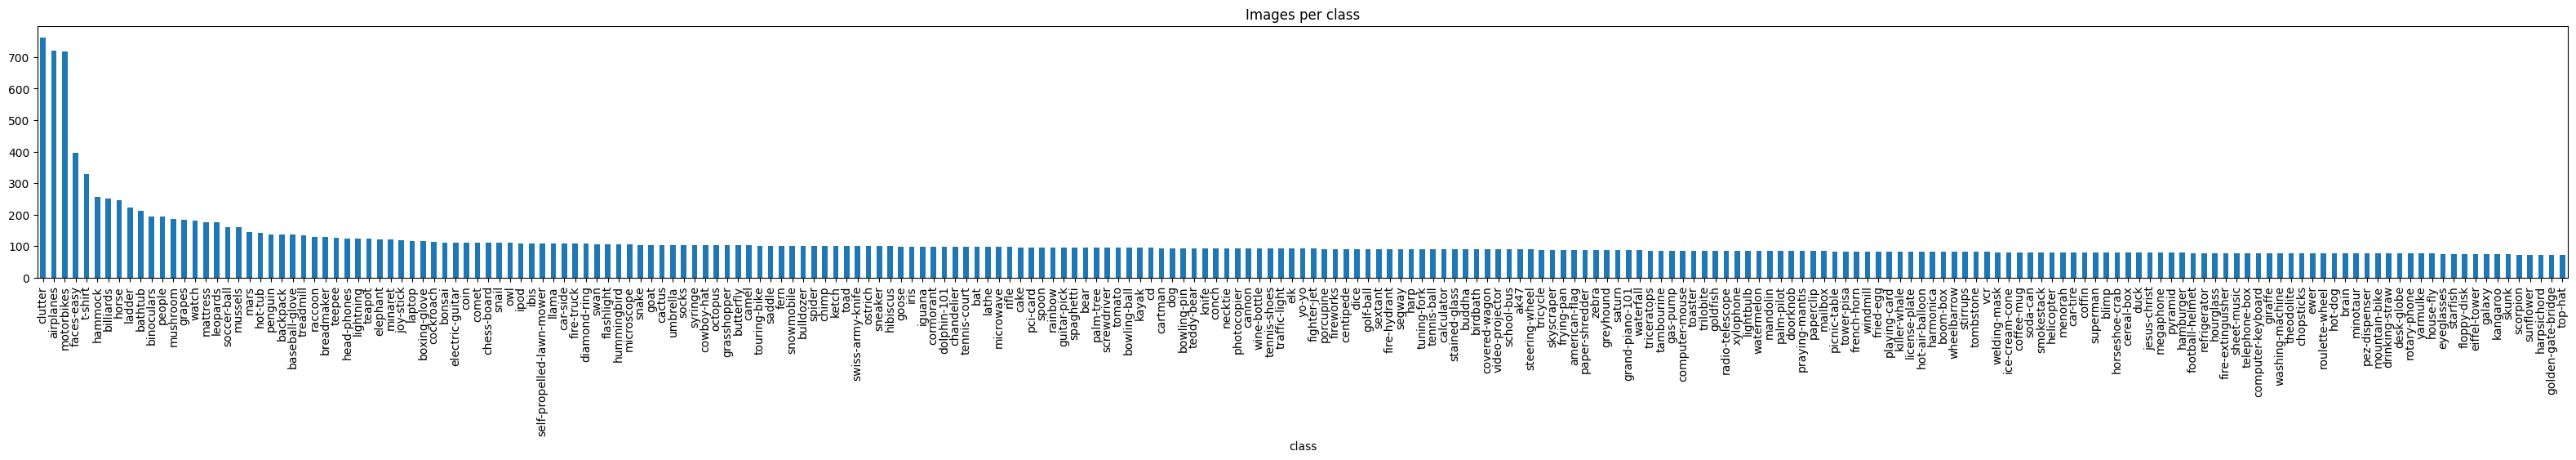

In [20]:
df['class'].value_counts().plot(kind='bar', figsize=(40,4))
plt.title("Images per class")
plt.show()

In [21]:
df[['width','height']].describe()

,width,height
count,25557.000000,25557.000000
mean,371.891810,326.044137
std,229.095197,206.907445
min,100.000000,97.000000
25%,238.000000,200.000000
50%,300.000000,280.000000
75%,442.000000,397.000000
max,7913.000000,7913.000000


In [22]:
print("Data set summary:")
print("Total categories:", len(folders))
print("Total images:", sum(folder_counts.values()))
print("Empty folders:", empty_folders if empty_folders else "None")
print("Corrupted images:", len(bad_files))
print("File extensions:", extensions)

Data set summary:
Total categories: 233
Total images: 25558
Empty folders: None
Corrupted images: 0
File extensions: ['*.jpg', '*.jpeg', '*.png']
